In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv
/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip


In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plotting packs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLP packs
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from textblob import TextBlob , Word
import re 
import string

##Wordcloud Modules
from wordcloud import WordCloud , STOPWORDS

#Machine learning Packs
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [3]:
train = pd.read_csv('../input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', delimiter="\t")
test = pd.read_csv('../input/word2vec-nlp-tutorial/testData.tsv.zip', delimiter="\t")

In [4]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [6]:
df = train.append(test)

## Data Cleaning

In [7]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [8]:
df['review']=df['review'].str.lower().str.replace('[^\w\s]','').str.replace('\d+','').str.replace('\n',' ').replace('\r','').str.replace("[^a-zA-Z0-9\s]",'') 

In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

df['review'] = df['review'].apply(lambda x : word_tokenize(x.lower())) # cumle -> words
df["review"] = df["review"].apply(lambda x : [word for word in x if word not in STOPWORDS]) # stop words cikarma
df["review"] = df["review"].apply(lambda x : [WordNetLemmatizer().lemmatize(word) for word in x]) # kelimelerin kok halleri
df["review"] = df["review"].apply(lambda x : " ".join(x)) # kelimleri birleştirdik

## Word Cloud

In [10]:
def wc(data,bgcolor): # word cloud
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,max_words=100, min_word_length=4, contour_width=3, contour_color='steelblue')
    wc.generate(" ".join(data)) # tum kelimeleri birlestirip tek 1 string haline getirir
    plt.imshow(wc)
    plt.axis("off")

In [11]:
df

,id,sentiment,review
0,5814_8,1.0,stuff going moment mj ive started listening mu...
1,2381_9,1.0,classic war world timothy hines entertaining f...
2,7759_3,0.0,film start manager nicholas bell giving welcom...
3,3630_4,0.0,must assumed praised film greatest filmed oper...
4,9495_8,1.0,superbly trashy wondrously unpretentious s exp...
...,...,...,...
24995,2155_10,NaN,sony picture classic im looking sonys got righ...
24996,59_10,NaN,always felt m merkerson never gotten role fitt...
24997,2531_1,NaN,disappointed movie familiar case read mark fuh...
24998,7772_8,NaN,opening sequence filled black white shot remin...


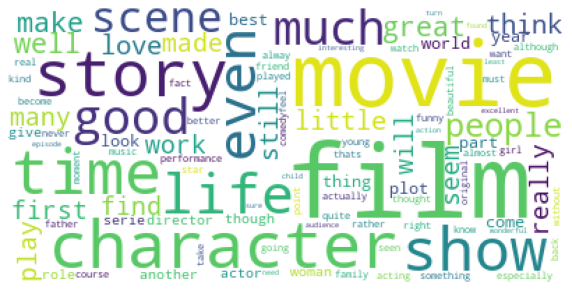

In [12]:
wc(df[df.sentiment==1.0].review, 'white')

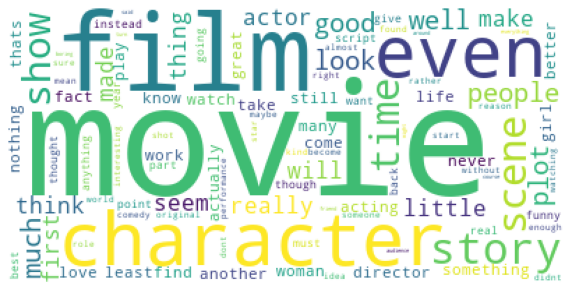

In [13]:
wc(df[df.sentiment==0.0].review, 'white')

## Top Words

In [14]:
def word_cleaner(data):
    words=[re.sub("[^a-zA-Z]"," ",i)for i in data] # noktalamalı kaldır
    words=[i.lower()for j in words for i in j.split()]#Splitting all the sentences into words# cümleleri kelimeye dönüştür
    words=[i for i in words if not i in set(stopwords.words("english"))]#removing stopwords
    words=[i for i in words if len(i)>2 ]#2 den büyük kelimeleri al # bu ozellik wordcloud da zaten var aslinda
    return words

<AxesSubplot:ylabel='sentiment'>

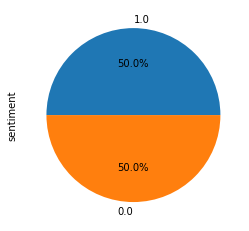

In [15]:
df["sentiment"].value_counts().plot.pie(autopct="%1.1f%%")

## Machine Learning

In [16]:
def nlp_analysis(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
    
    vectorizers=[CountVectorizer(), TfidfVectorizer()]
    ngrams = [(1,1), (1,2)]
    
    classifiers=[XGBClassifier(), GradientBoostingClassifier()]
    
    col_names = ['Classifier','Methods', 'N-Grams','Accuracy','Precision','Recall', 'F1']
    df_nlp = pd.DataFrame(columns=col_names)   
    
    for i in vectorizers:
        vec=i
        vec_name = i.__class__.__name__
        vec.stop_words='english'
        
        for j in ngrams:
            vec.ngram_range=j
            X_train_dtm = vec.fit_transform(X_train)
            X_test_dtm = vec.transform(X_test)
            
            for k in classifiers:
                pred = k.fit(X_train_dtm, y_train).predict(X_test_dtm)
                clas_name = k.__class__.__name__
                
                accuracy = accuracy_score(y_test, pred)
                precision = precision_score(y_test, pred, average='weighted')
                f1 = f1_score(y_test, pred, average='weighted')
                recall = recall_score(y_test, pred, average='weighted')
                
                df_entry = pd.DataFrame([[clas_name, vec_name, j, accuracy*100, precision*100, recall*100, f1*100]], 
                                        columns=col_names)
                df_nlp=df_nlp.append(df_entry)
    return df_nlp

In [17]:
df_train = df[:train.shape[0]]
df_test = df[train.shape[0]:]

In [18]:
nlp_analysis(df_train.review, df_train.sentiment.astype(int))

,Classifier,Methods,N-Grams,Accuracy,Precision,Recall,F1
0,XGBClassifier,CountVectorizer,"(1, 1)",84.84,84.858046,84.84,84.836797
0,GradientBoostingClassifier,CountVectorizer,"(1, 1)",80.42,80.791737,80.42,80.352663
0,XGBClassifier,CountVectorizer,"(1, 2)",84.56,84.564557,84.56,84.558814
0,GradientBoostingClassifier,CountVectorizer,"(1, 2)",80.38,80.767841,80.38,80.309716
0,XGBClassifier,TfidfVectorizer,"(1, 1)",84.60,84.616636,84.60,84.596926
0,GradientBoostingClassifier,TfidfVectorizer,"(1, 1)",80.56,80.914548,80.56,80.496319
0,XGBClassifier,TfidfVectorizer,"(1, 2)",84.18,84.205081,84.18,84.175550
0,GradientBoostingClassifier,TfidfVectorizer,"(1, 2)",80.36,80.583184,80.36,80.317768


## Deep Learning

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'].values)
sequences = tokenizer.texts_to_sequences(df['review'].values)
df_dtm=pad_sequences(sequences)

df_train_dtm = df_dtm[:train.shape[0]]
df_test_dtm = df_dtm[train.shape[0]:]

In [20]:
df_dtm.shape

(50000, 1423)

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Bidirectional, BatchNormalization

model=Sequential()
model.add(Embedding(50000, 500, input_length=df_train_dtm.shape[1])),
model.add(Bidirectional(LSTM(64,  activation='relu'))),

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
model.summary() 

2022-08-27 14:33:13.645439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 14:33:13.650521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 14:33:13.651249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 14:33:13.652465: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1423, 500)         25000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               289280    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

In [22]:
from tensorflow.keras.utils import to_categorical
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(df_train_dtm, train.sentiment.astype(int), validation_split=0.20, epochs=3, batch_size=289, verbose=1)

2022-08-27 14:33:18.707276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
70/70 [==============================] - 374s 5s/step - loss: nan - accuracy: 0.6406 - val_loss: nan - val_accuracy: 0.4944
Epoch 2/3
70/70 [==============================] - 370s 5s/step - loss: nan - accuracy: 0.5014 - val_loss: nan - val_accuracy: 0.4944
Epoch 3/3
70/70 [==============================] - 366s 5s/step - loss: nan - accuracy: 0.5014 - val_loss: nan - val_accuracy: 0.4944


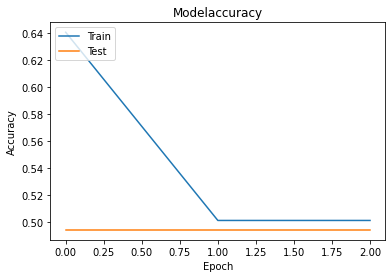

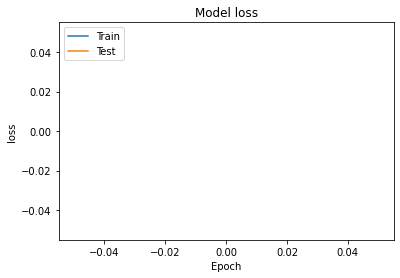

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Modelaccuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

## Submission

In [24]:
cv = CountVectorizer(stop_words="english")
df_train_dtm = cv.fit_transform(df.review.values)

df_train_dtm = df_dtm[:train.shape[0]]
df_test_dtm = df_dtm[train.shape[0]:]

In [25]:
gbc = GradientBoostingClassifier()
gbc.fit(df_train_dtm, df_train.sentiment.astype(int))
pred = gbc.predict(df_test_dtm)

In [26]:
pred

array([0, 0, 1, ..., 0, 0, 0])

In [27]:
submission = pd.read_csv('../input/word2vec-nlp-tutorial/sampleSubmission.csv')
submission.loc[:, 'sentiment'] = pred.astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()

,id,sentiment
0,12311_10,0
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1
